# Machine Learning and Python - Ατομική εργασία


## Install and import libraries
Εργαζόμαστε σε περιβάλλον Google Colaboratory και εγκαθιστούμε στο virtual machine τη βιβλιοθηκη `selenium` και τον Chrome web driver που θα χρησιμοποιήσουμε για το data scraping από το marinetraffic.com:

In [1]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time

ModuleNotFoundError: No module named 'plotly'

## I. Fetching the data
Η στρατηγική για το data scraping συνίσταται στα παρακάτω:


1.   Εντοπισμός του πίνακα με τα πλοία
2.   Parsing των στοιχείων του πίνακα που μας ενδιαφέρουν (όνομα πλοίου, συντεταγμένες, λιμάνια αναχώρησης - άφιξης κ.ο.κ).
3.   Εισαγωγή των στοιχείων αυτών υπό μορφή dictionary σε μια λίστα
4.   Εντοπισμός του input area και εισαγωγή της επόμενης σελίδας
5.   Επανάληψη της διαδικασίας για 5 σελίδες (20 πλοία / σελίδα = 100 πλοία)

Τέλος, η λίστα με τα dictionaries που περιέχουν τα στοιχεία των πλοίων που συλλέξαμε στα παραπάνω βήματα εισάγεται σε Pandas data frame για την παραγγγή των οπτικοποιήσεων και των περιγραφικών μέτρων.

Σημειώνεται πως ο κώδικας λειτουργεί όσο η δομή των HTML σελίδων του marinetraffic παραμένουν αναλλοίωτες - σε περίπτωση που αλλάξουν (π.χ. μεταβληθούν τα ονόματα των div κλάσεων) θα πρέπει να προσαρμοστεί ανάλογα και ο κώδικας προκειμένου να μπορεί επιτυχώς να εντοπίζει τα στοιχεία των πλοίων.



In [2]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("lang=en")
options.add_argument("start-maximized")
options.add_argument("disable-infobars")
options.add_argument("--disable-extensions")
options.add_argument("--incognito")
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)

# this is the marinetraffic vessels database url which we will use to parse vessel data
url = "https://www.marinetraffic.com/en/data/?asset_type=vessels&columns=flag,shipname,recognized_next_port,current_port,ship_type,area_local,lat_of_latest_position,lon_of_latest_position,speed,year_of_build,dwt"

# get above url with selenium driver and wait 10 secs to load
driver.get(url)

# instantiate a counter to 
vessel_count = 0

# instantiate list which will store the scraped vessel properties
vessel_list = []

# set to true to enter the loop
checking_for_vessels = True

while checking_for_vessels:
    
    # wait for page to load
    driver.implicitly_wait(10)

    # locate the table element in the vessels database
    table = driver.find_element(By.CLASS_NAME, 'ag-body-container')
    
    # locate the rows in the table
    elements =table.find_elements(By.CSS_SELECTOR, 'div[role="row"]')

    for i in range(len(elements)):

        vessel_name = elements[i].find_element(By.CLASS_NAME, 'ag-cell-content-link').text
        
        print('processing vessel: no', i, vessel_name)
        
        # store the desired vessel properties in a dictionary
        mydict = {}
        mydict['vessel_name'] = elements[i].find_element(By.CLASS_NAME, 'ag-cell-content-link').text
        mydict['country'] = elements[i].find_element(By.CLASS_NAME, 'flag-icon').get_attribute('title')
        mydict['dest_port'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="recognized_next_port"] .ag-cell-content').text 
        mydict['current_port'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="current_port"] .ag-cell-content').text 
        mydict['vessel_type'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="ship_type"] .ag-cell-content img').get_attribute('title')
        mydict['local_area'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="area_local"] .ag-cell-content').text 
        mydict['lat'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="lat_of_latest_position"] .ag-cell-content').text
        mydict['lon'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="lon_of_latest_position"] .ag-cell-content').text 
        mydict['speed'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="speed"] .ag-cell-content').text 
        mydict['year_of_build'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="year_of_build"] .ag-cell-content').text
        mydict['dwt'] = elements[i].find_element(By.CSS_SELECTOR, '[col-id="dwt"] .ag-cell-content').text

        # finally append the dictionary with the vessel properties in the list
        vessel_list.append(mydict)

        vessel_count += 1

    # locate the pagination buttons and text below the vessels table, get current page and max pages returned
    pagination_container = driver.find_element(By.CLASS_NAME, 'MuiTablePagination-actions')
    page_number = pagination_container.find_element(By.CSS_SELECTOR, 'input').get_attribute('value')
    max_page_number = pagination_container.find_element(By.CLASS_NAME, 'MuiFormControl-root').get_attribute('max')
    print('--- FINISHED PROCESSING PAGE NUMBER', page_number, 'OF', max_page_number, '---')

    # each page shows 20 vessels, so we stop the loop at the 5th page to get 100 vessels
    if int(page_number) == 5:
        checking_for_vessels = False
        print('--- FINISHED SCRIPT ---')
    else:
        # proceed to the next page
        print('--- PROCEEDING TO NEXT PAGE ---')
        
        # hide the bar containing the privacy buttons and text which overlaps the previous / next buttons
        t1= driver.find_element(By.CLASS_NAME, 'qc-cmp2-summary-buttons')
        t2= driver.find_element(By.CLASS_NAME, 'qc-cmp2-footer')
        t3= driver.find_element(By.ID, 'qc-cmp2-ui')
        t4= driver.find_element(By.CLASS_NAME, 'qc-cmp-cleanslate')
        
        driver.execute_script("arguments[0].style.visibility='hidden'", t1)
        driver.execute_script("arguments[0].style.visibility='hidden'", t2)
        driver.execute_script("arguments[0].style.visibility='hidden'", t3)
        driver.execute_script("arguments[0].style.visibility='hidden'", t4)
        
        # set the next page

        # locate the input area
        inputarea = pagination_container.find_element(By.CLASS_NAME, 'MuiInput-input')
        
        # clear the current value
        inputarea.clear()

        # set the new value
        inputarea.send_keys(int(page_number)+1)

        # wait for the table to refresh before restarting the loop
        time.sleep(5)

NameError: name 'webdriver' is not defined

In [183]:
# create pandas dataframe
df_master = pd.DataFrame.from_records(vessel_list)
# temporary backup dataframe for data transformations
df = df_master

# save to excel for backup
df.to_excel('dataset.xlsx')

# show top 10 records
df.head(10)

,vessel_name,country,dest_port,current_port,vessel_type,local_area,lat,lon,speed,year_of_build,dwt
0,QUEEN MARY 2,Bermuda,SOUTHAMPTON,SOUTHAMPTON,Passenger,English Channel,50.90431,-1.428678,0.0 knots,2003,19189
1,EVER GIVEN,Panama,NINGBO,NINGBO,Cargo,East China Sea,29.78139,122.0196,0.0 knots,2018,199692
2,ECLIPSE,Bermuda,-,-,Pleasure Craft,East Mediterranean,36.72163,28.94885,0.0 knots,2010,1480
3,QUEEN ELIZABETH,Bermuda,PALMA DE MALLORCA,PALMA DE MALLORCA,Passenger,Balearic Sea,39.55328,2.634067,0.0 knots,2010,7685
4,TIME BANDIT,USA,-,HOMER,Fishing,Gulf of Alaska,59.699,-149.228,9.2 knots,1991,-
5,OASIS OF THE SEAS,Bahamas,-,NEW YORK,Passenger,US East Coast,40.66438,-74.06895,0.0 knots,2009,15000
6,PAUL R TREGURTHA,USA,ST CLAIR,-,Cargo,Lake Superior,46.81845,-84.96754,12.4 knots,1981,-
7,NORTHWESTERN,USA,DUTCH HARBOR,DUTCH HARBOR,Fishing,Alaska,53.86986,-166.5546,0.0 knots,1977,-
8,WIZARD,USA,CORDOVA,SEATTLE,Fishing,US West Coast,47.66665,-122.3895,0.0 knots,1945,1400
9,DISNEY MAGIC,Bahamas,DOVER,DOVER,Passenger,English Channel,51.11215,1.323048,0.0 knots,1998,8452


### Προεπεξεργασία συνόλου δεδομένων

In [199]:
# replace vessel_name, vessel_type, dest_port, current_port, local_area "-" values with UNKNOWN
df['vessel_name'] = df['vessel_name'].replace(['-'],'UNKNOWN')
df['vessel_type'] = df['vessel_type'].replace(['-'],'UNKNOWN')
df['dest_port'] = df['dest_port'].replace(['-'],'UNKNOWN')
df['current_port'] = df['current_port'].replace(['-'],'UNKNOWN')
df['local_area'] = df['local_area'].replace(['-'],'UNKNOWN')

# replace "-" in dwt with NaN, replace with mean value and convert to integer
df['dwt'] = df['dwt'].replace(r'-', np.nan, regex=True)
df["dwt"] = df["dwt"].astype(float)
df["dwt"].fillna(df["dwt"].mean(), inplace=True)
df["dwt"] = df["dwt"].astype(int)

# replace "-" in year_of_build with NaN, replace with mean value and convert to integer
df['year_of_build'] = df['year_of_build'].replace(r'-', np.nan, regex=True)
df["year_of_build"] = df["year_of_build"].astype(float)
df["year_of_build"].fillna(df["year_of_build"].mean(), inplace=True)
df["year_of_build"] = df["year_of_build"].astype(int)

# remove "knots" string from speed column and transform to float
df["speed"] = df["speed"].str.replace("knots","")
df["speed"] = df["speed"].astype(float)

## II. Visualise the data

### Διαγράμματα με τις κατανομές των πλοίων ανά κατηγορία τους και ανά περιοχή (Area) που βρίσκονται.
Στο δεύτερο αυτό διάγραμμα να προσθέσετε και μια κατηγορηματική μεταβλητή (Hue στο Seaborn) που να απεικονίζει και τα είδη των πλοίων ανά περιοχή που έχετε στο data set σας.

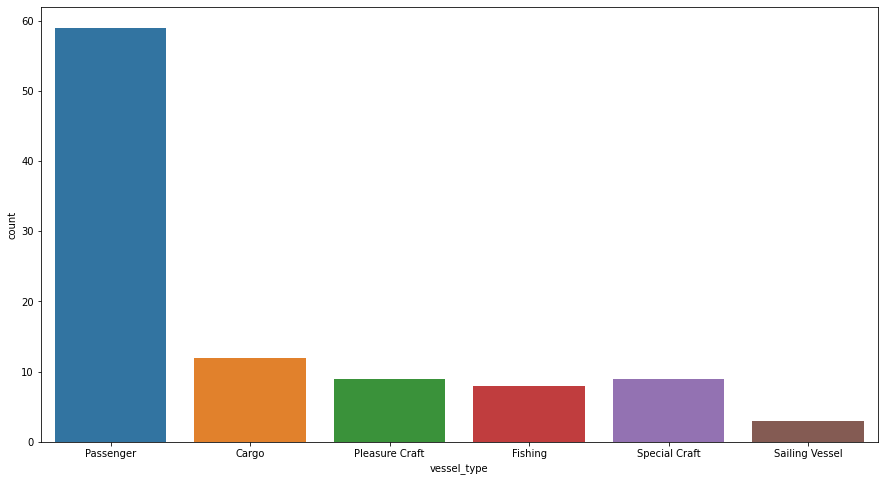

In [185]:
plt.figure(figsize=(15,8))
sns.countplot(data=df, x="vessel_type")

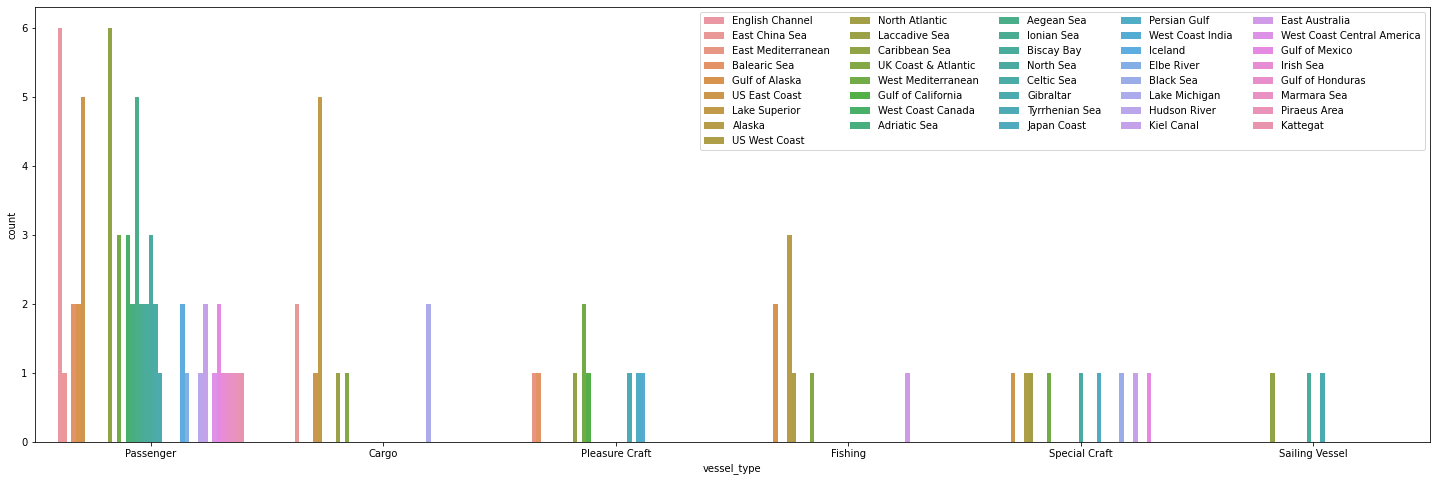

In [186]:
plt.figure(figsize=(25,8))
sns.countplot(data=df, x="vessel_type", hue="local_area")
plt.legend(loc='upper right', ncol=5)

### Διάγραμμα που να δείχνει τη συσχέτιση ανάμεσα στο είδος του πλοίου και την ταχύτητα του.
(θα πρέπει να μπορείτε να εξηγήσετε ποιοτικά το διάγραμμα που θα δείξετε)

Στο παρακάτω διαγραμμα boxplot παρουσιάζεται η κατανομή των πλοίων με βάση το είδος τους ώς προς την ταχύτητά τους. Παρατηρούμε την ύπαρξη μιας ακραίας τιμής στα πλοία κατηγορίας "pleasure craft" ενώ οι κατηγορίες "passenger" και "cargo" έχουν τη μεγαλύτερη διασπορά στις ταχύτητες που έχουν καταγραφεί. Οι μικρότερες ταχύτητες παρατηρούνται στα πλοία τύπου "sailing vessel" ενώ οι μεγαλύτερες σε αυτά τύπου "passenger".

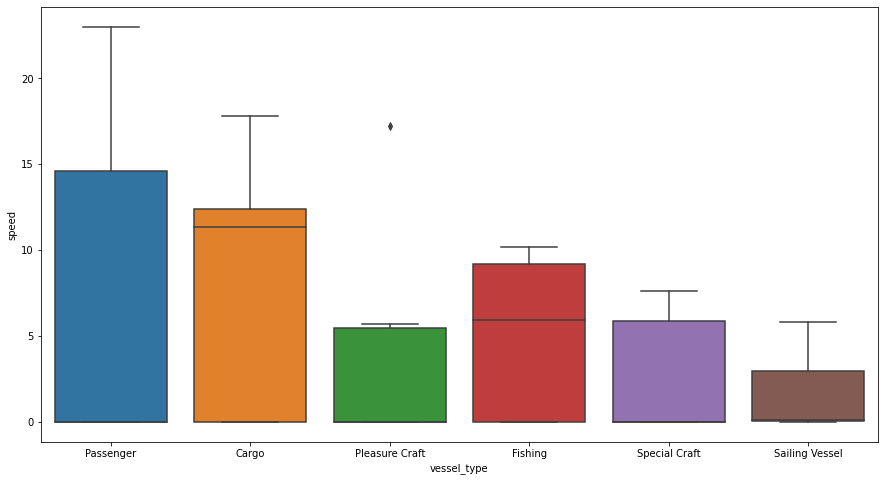

In [187]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, x="vessel_type", y="speed")

### Ένα Heat map που θα δείχνει κάθε μία από τις περιοχές (Area) που έχετε στο data σας, τι είδους πλοία πλέουν σε αυτές.

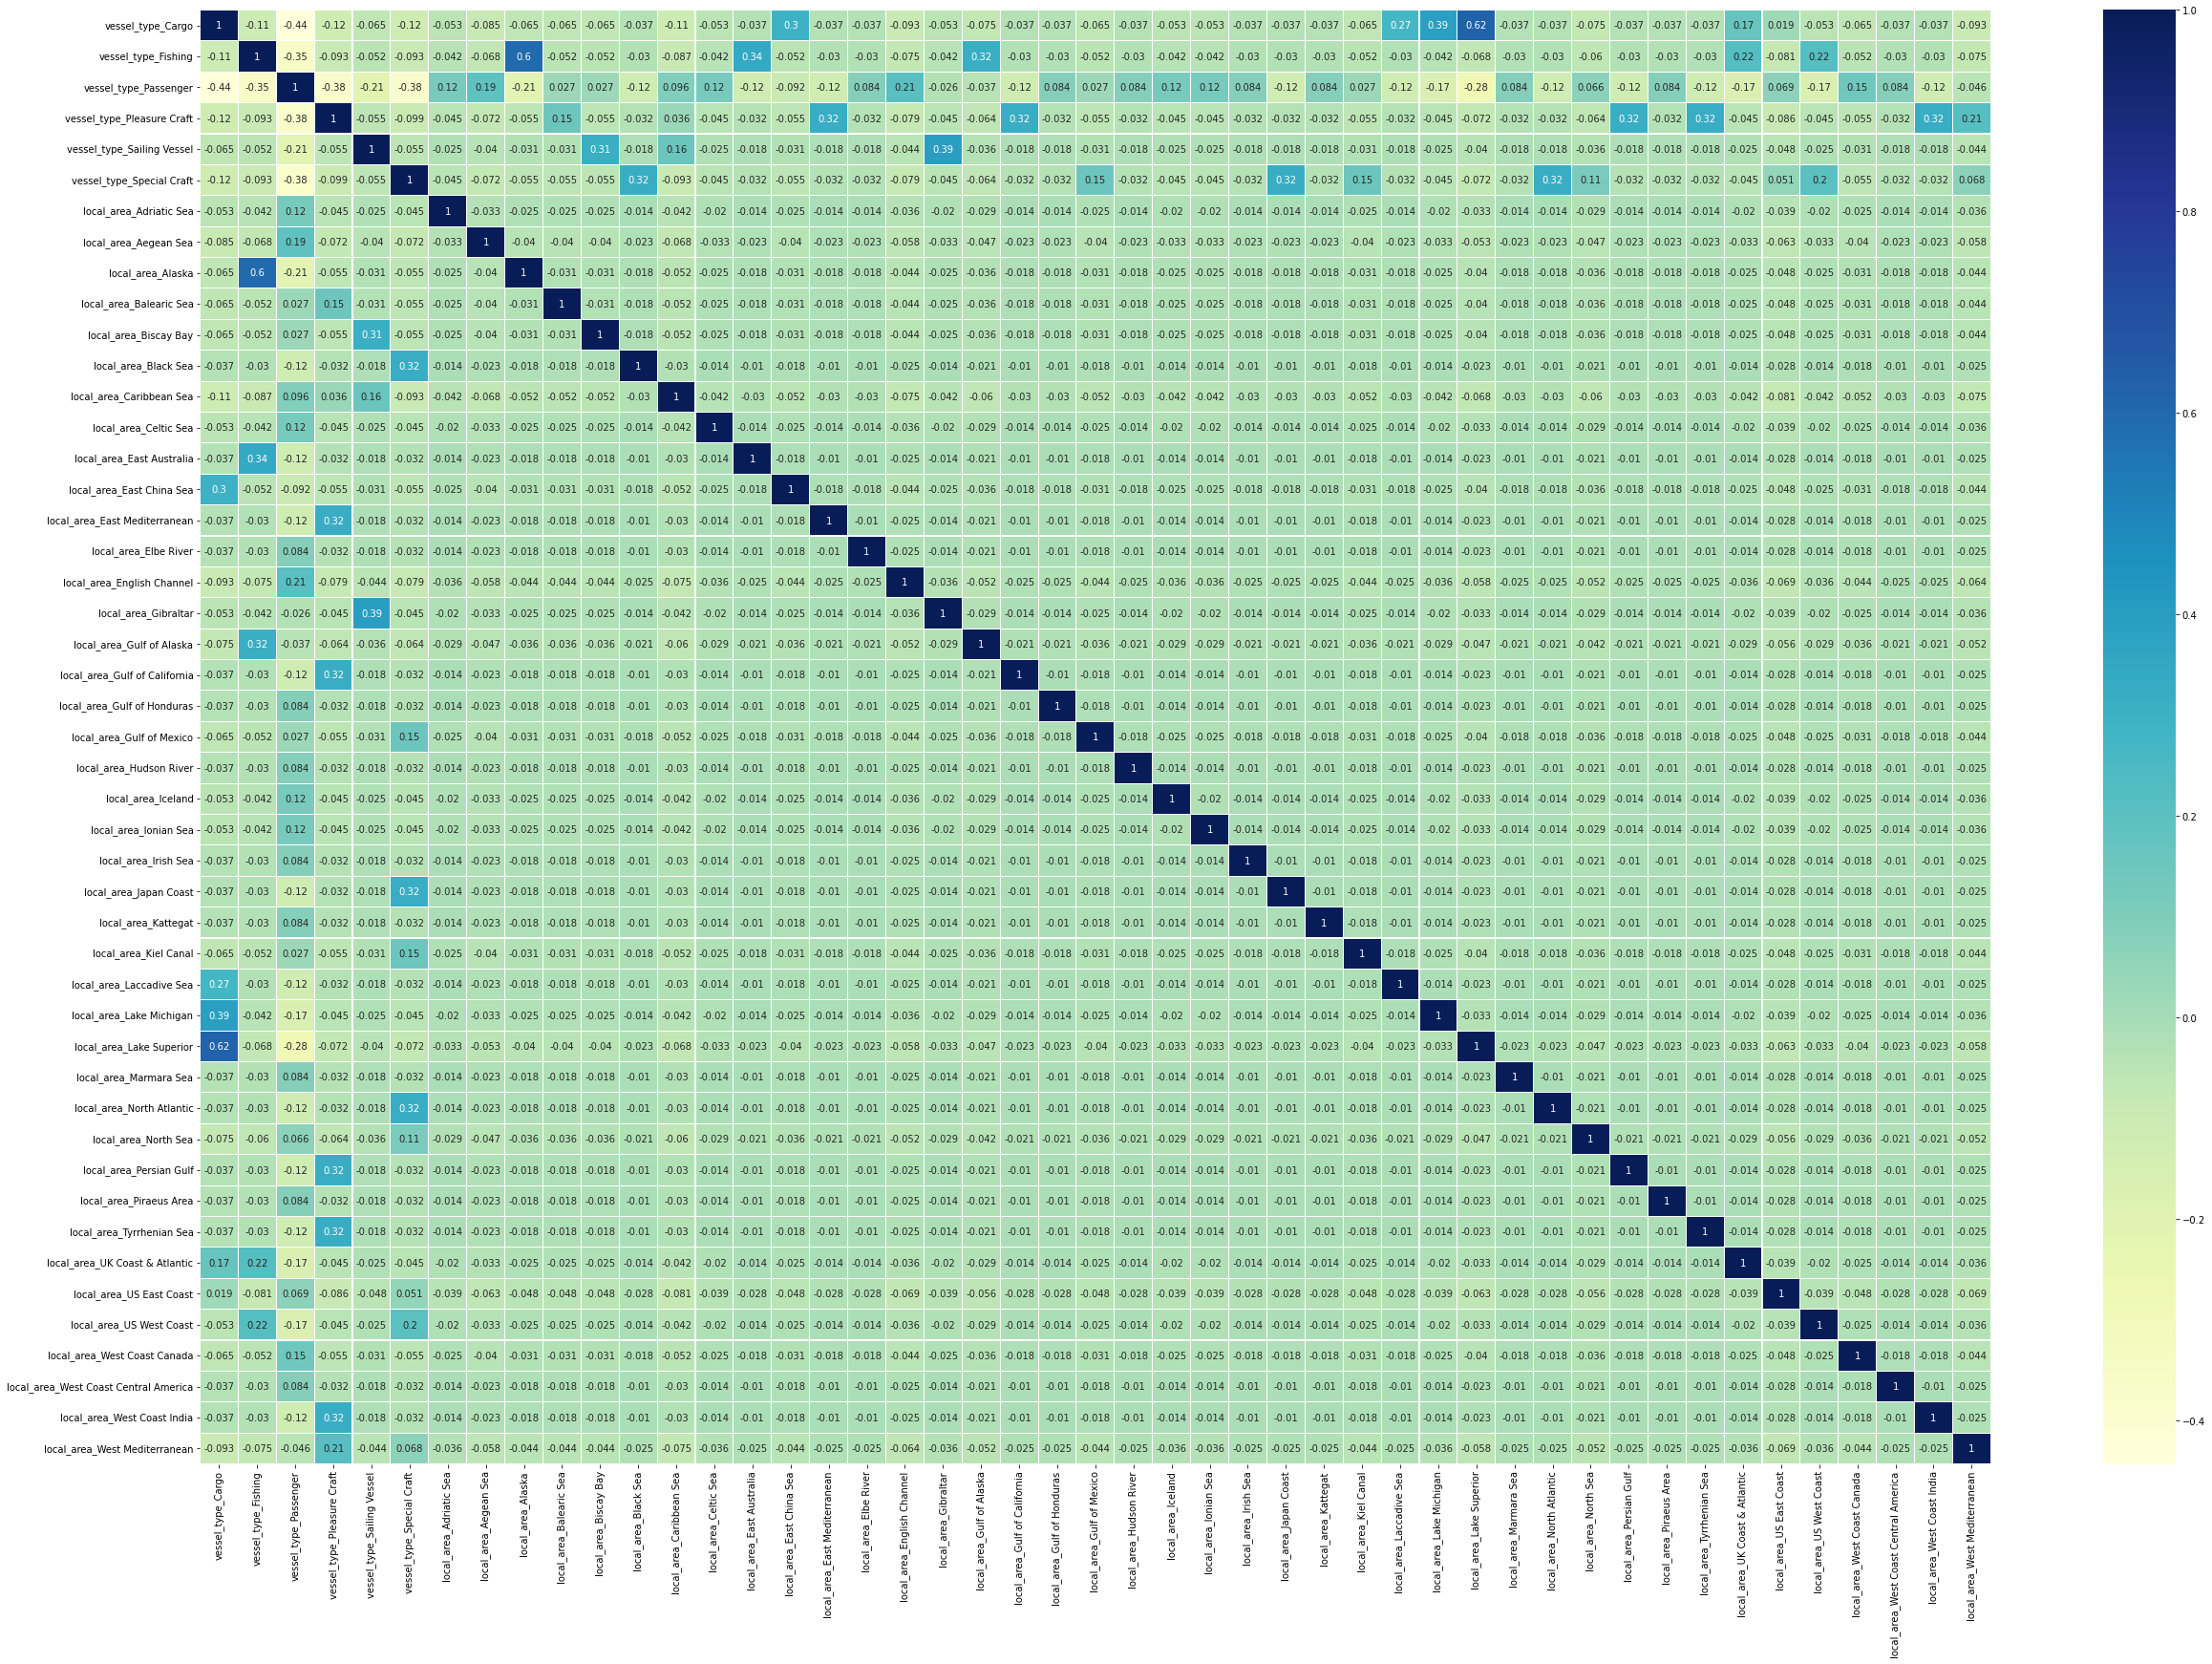

In [188]:
df_heatmap = df[['vessel_type','local_area']]
dfDummies = pd.get_dummies(df_heatmap)

plt.figure(figsize=(42,28))
sns.heatmap(dfDummies.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

### Ένα Scatter plot που θα δείχνει τις χρονολογίες ναυπήγησης των πλοίων σε σχέση με την χωρητικότητα τους.

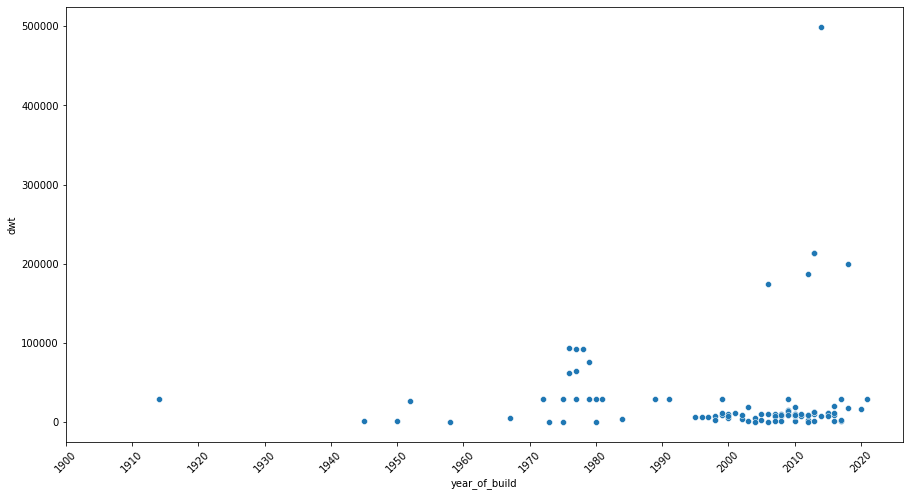

In [189]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = df, x = "year_of_build", y = "dwt")
plt.xticks(range(1900,2030,10),rotation=45)
plt.yticks(range(0,600000, 100000))
plt.show()

### Ένα διάγραμμα που θα αναπαριστά τις συντεταγμένες των πλοίων.

In [190]:
fig = px.scatter_geo(df,lat='lat', lon='lon')
fig.show()

## III. Descriptive statistics

### Ποια είναι η μέση ταχύτητα των πλοίων ανά κατηγορία πλοίων που έχετε στο data set σας
Η μέση ταχύτητα ανά κατηγορία πλοίου απεικονίζεται στον παρακάτω πίνακα.

In [191]:
df.groupby(['vessel_type'])['speed'].mean()

vessel_type
Cargo             7.683333
Fishing           5.075000
Passenger         6.249153
Pleasure Craft    3.166667
Sailing Vessel    1.966667
Special Craft     2.266667
Name: speed, dtype: float64

### Ποια είναι η μέση ταχύτητα των πλοίων ανά περιοχή (Area) που έχετε στο dataset σας
Η μέση ταχύτητα των πλοίων ανά περιοχή απεικονίζεται στον παρακάτω πίνακα.

In [192]:
df.groupby(['local_area'])['speed'].mean()

local_area
Adriatic Sea                   0.050000
Aegean Sea                     2.220000
Alaska                         3.966667
Balearic Sea                   1.833333
Biscay Bay                    10.866667
Black Sea                      0.000000
Caribbean Sea                  8.837500
Celtic Sea                     9.100000
East Australia                 0.000000
East China Sea                 5.066667
East Mediterranean             0.000000
Elbe River                     0.000000
English Channel                1.966667
Gibraltar                      7.650000
Gulf of Alaska                12.450000
Gulf of California             5.700000
Gulf of Honduras              23.000000
Gulf of Mexico                 6.733333
Hudson River                   0.000000
Iceland                        7.500000
Ionian Sea                     0.000000
Irish Sea                      0.000000
Japan Coast                    0.100000
Kattegat                       0.000000
Kiel Canal                   

### Ποια χώρα έχει τα περισσότερα (ανεξαρτήτου είδους) πλοία
Η χώρα με τα περισσότερα (ανεξαρτήτου είδους) πλοία είναι η "Bahamas".

In [193]:
print('The country with the most vessels is:', df['country'].describe().top)

The country with the most vessels is: Bahamas


### Ποιο είναι το πλοίο με τη μεγαλύτερη και ποιο με τη μικρότερη χωρητικότητα
Το πλοίο με τη μεγαλύτερη χωρητικότητα είναι το "PIONEERING SPIRIT"

Το πλοίο με τη μικρότερη χωρητικότητα είναι το "MALTESE FALCON"

In [194]:
df.iloc[df['dwt'].idxmax()]

vessel_name      PIONEERING SPIRIT
country                      Malta
dest_port            FREDERIKSHAVN
current_port               UNKNOWN
vessel_type          Special Craft
local_area               North Sea
lat                       56.34217
lon                       6.991667
speed                          5.9
year_of_build                 2014
dwt                         499125
Name: 27, dtype: object

In [195]:
df.iloc[df['dwt'].idxmin()]

vessel_name          MALTESE FALCON
country                       Malta
dest_port                  VALLETTA
current_port               VALLETTA
vessel_type          Pleasure Craft
local_area       West Mediterranean
lat                        35.89133
lon                          14.517
speed                           0.1
year_of_build                  2006
dwt                             147
Name: 68, dtype: object

### Ποιο λιμάνι έχει την περισσότερη κίνηση (Αναχωρήσεις και Αφίξεις) από τις διαδρομές που είναι προγραμματισμένες στα πλοία που έχετε στο data set σας

Το λιμάνι με τις περισσότερες αναχωρήσεις και αφίξεις αθροιστικά είναι το 'SOUTHAMPTON'.

In [201]:
df_ports = df[['dest_port','current_port']]

concatvalues = np.concatenate([df_ports.dest_port.values,df_ports.current_port.values])

df_ports_combined = pd.concat([df_ports,pd.DataFrame(concatvalues)], ignore_index=True, axis=1)
df_ports_combined.columns = np.append(df_ports.columns.values, "ports_combined")

df_ports_combined['ports_combined'].value_counts()

UNKNOWN            57
SOUTHAMPTON         6
DULUTH SUPERIOR     5
NEW YORK            4
KIEL                4
                   ..
CHIOS               1
SIRACUSA            1
INDIANA HARBOR      1
LA PALLICE          1
PIRAEUS             1
Name: ports_combined, Length: 89, dtype: int64

### Ποιο είναι το πιο συνηθισμένο είδος πλοίου
Το πιο συνηθισμένο είδος πλοίου είναι το "Passenger".

In [202]:
print('The most frequent vessel type is:', df['vessel_type'].describe().top)

The most frequent vessel type is: Passenger


--- ΤΕΛΟΣ ΕΡΓΑΣΙΑΣ ---

---

